# Project One - Working with NHANES Dataset

Selected variables were selected from NHANES dataset from 2015-2016. The data contains information on the following components.
1) Life style factors - Smoking, Drinking
2) Anthropometric measurements 
3) Blood pressure profile
4) Subjects' Profile - Ethnicity, No. of Household member, Income ratio, Insurance coverage, Marital Status, Age and Education Level

For simplified analysis, subjects with NA observed will be dropped.


References
Public Dataset - NHANES dataset and Codebook can be found (here)[https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx]

## Importing packages

In [37]:
import matplotlib.pyplot as plt # for plotting
import pandas as pd # for wrangling data
import numpy as np # managing numbers
import seaborn as sns
import scipy

## Importing and Reading Dataset


In [ ]:
df= pd.read_csv("https://raw.githubusercontent.com/meRveet/pythonprojects/main/nhanesanalysis/nhanes_2015_2016.txt")
df.head()

## Exploratory Data Analysis

### Pre-processing data for analysis
- Dichotomising drinking data into 'drink' column
- Averaging BPXSY1 and BPXSY2 to syavg
- Averaging BPXDI1 and BPXDI2 to diavg


In [ ]:
df['drink'] = 0
df.drink[((df.ALQ101 ==1) | (df.ALQ110==1) | (df.ALQ130 == any(range(1,16))))] = 1
df['syavg'] = (df.BPXSY1 + df.BPXSY2)/2
df['diavg'] =(df.BPXDI1 + df.BPXDI2)/2

print(df.drink.shape)
print(df.info())

### Descriptive Data Analysis

Dataset contains a mixture of continuous and categorical data. Hence, some data might not be meaningful when it is used with .describe function. Values are also encoded with missing or refused codes which will need to be pre-processed before any descriptive data can be meaningful. 

ID: SEQN
Continuous: ALQ130, RIDAGEYR, WTINT2YR, INDFMPIR, BPXSY1, BPXDI1, BPXSY2, BPXDI2, BMXWT, BMXHT, BMXBMI, BMXLEG, BMXARML, BMXARMC, BMXWAIST
Categorical: ALQ101, ALQ110, SMQ020, RIAGENDR, RIDRETH1, DMDCITZN, DMDEDUC2, DMDMARTL, DMDHHSIZ, HIQ210, drink
Weights related variables:  WTINT2YR, SDMVPSU, SDMVSTRA

In [ ]:
# Indexing continuous data for descriptive analysis.
dfcont= df.loc[:,['SEQN','ALQ130', 'RIDAGEYR', 'INDFMPIR', 'syavg','diavg', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST']]
print(dfcont.info())

# Missing or refused data are treated as Nan
dfcont.ALQ130[(dfcont.ALQ130==777)| (dfcont.ALQ130 == 999)] = np.nan
dfcont.ALQ130.value_counts(dropna=False).sort_index()

In [ ]:
# # Selecting Categorical Columns
dfcat = df.loc[:,['SEQN','ALQ101', 'ALQ110', 'SMQ020', 'RIAGENDR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'HIQ210', 'drink']]
dfcat.info()

# Treating Refused or Missing Data as Nan
dfcat[(dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 7) | (dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 9) | (dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 0)] = np.nan
dfcat.loc[(dfcat.loc[:,'DMDMARTL'] == 77) |(dfcat.loc[:,'DMDMARTL'] == 99)] = np.nan



In [ ]:
# Looking at the mean, sd, min, max and quantiles of the data. *SEQN belongs to Subject ID.
dfcont.describe()

### Visualising datasets

In [ ]:
#Quick plots to visualise continuous data distribution 
for col in dfcont.columns: 
    try:      
        dfcont[col] = pd.to_numeric(dfcont[col]) 
        dfcont.hist(column=col,rwidth=.6)
    except ValueError:
        print('This column can not be represented as a histogram')


In [ ]:
#Quick plots to visualise categorical data distribution
for col in dfcat.columns: 
    try:      
        dfcat[col] = pd.to_numeric(dfcat[col]) 
        dfcat.hist(column=col,rwidth=.6)
    except ValueError:
        print('This column can not be represented as a histogram')

In [ ]:
# Correlation matrix for continuous dataset
dfcontcorr = dfcont.corr()


# Plotting of Corr Heatmap
mask = np.zeros_like(dfcont.corr())
mask
mask[np.triu_indices_from(mask)]= True
fig = plt.figure(constrained_layout=True)

with sns.axes_style('white'):
        f, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(dfcont.corr(), mask=mask, vmax =.3, square = True, cmap= sns.diverging_palette(10,220, as_cmap=True))
        plt.title("Correlation Matrix Heatmap for Continuous Variable")
        plt.show()

### Visualising Data Variables
  - Comparing the the differences between Ethnic Groups
    - BMI
    - Smoking
    - Drinking
- Explore if Income affects their BMI outcome
  - Compare within sample population
  - Compare between each Ethnic group
- Explore if education status affect their BMI outcome
  - Compare within sample population
  - Compare between each Ethnic group

#### BMI Comparison Between Ethnic Groups

In [ ]:
#Concat selected columns
pd.concat([dfcat.loc[:,'RIAGENDR'],dfcat.loc[:,'RIDRETH1'],dfcont.loc[:,'BMXBMI']], axis=1)

In [ ]:

#Function that describe and plot. 
def quantitative_summarized(df, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    df: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    plt.clf()
    series = df[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts().sort_index())

    sns.boxplot(x=x, y=y, hue=hue, data=df, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=df,
                      palette=palette, ax=ax)

    plt.show()

bmigeneth= pd.concat([dfcat.loc[:,'RIAGENDR'],dfcat.loc[:,'RIDRETH1'],dfcont.loc[:,'BMXBMI']], axis=1)

#Boxplot comparision between gender, ethnic for BMI
quantitative_summarized(bmigeneth, x='RIDRETH1', y='BMXBMI', hue='RIAGENDR')

In [ ]:
#Concat for drinking data
alqgeneth= pd.concat([dfcat.loc[:,'RIAGENDR'], dfcat.loc[:,'RIDRETH1'], dfcont.loc[:,'ALQ130']], axis=1)

#Function that describe and plot. 
def quantitative_summarized(df, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    df: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    plt.clf()
    series = df[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts().sort_index())

    sns.boxplot(x=x, y=y, hue=hue, data=df, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=df,
                      palette=palette, ax=ax)

    plt.show()


#Boxplot comparision between gender, ethnic for drinking data
quantitative_summarized(alqgeneth, x='RIDRETH1', y='ALQ130', hue='RIAGENDR')

- Ethnic 1,2 and 4 are observed to have a higher BMI for the females.With 4 having a wider SD compared to the rest. 

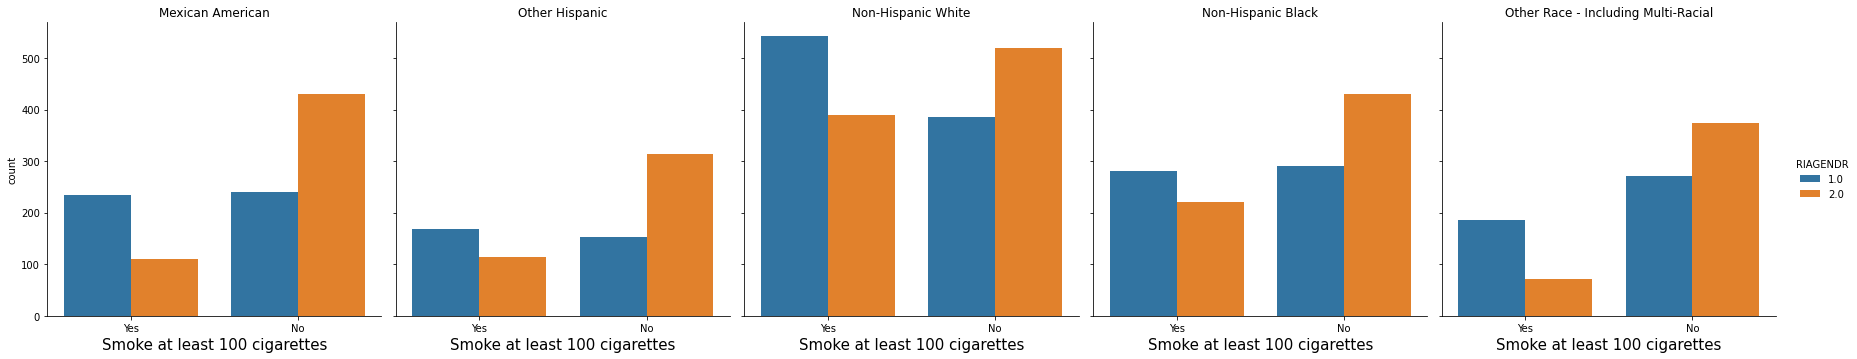

In [31]:
#Concat for Smoking data
smgeneth= pd.concat([dfcat.loc[:,'RIAGENDR'], dfcat.loc[:,'RIDRETH1'], dfcat.loc[:,'SMQ020']], axis=1)

#Ploting facetgrid like catplots to compare between geneder, ethnic and smoking history
fig = sns.catplot(data=smgeneth, x='SMQ020', hue= 'RIAGENDR', col= 'RIDRETH1', kind= 'count')
fig.set_axis_labels('Smoke at least 100 cigarettes', fontsize=15)
fig.set_xticklabels(["Yes", "No"])
#Settings title for each facetgrid
axes = fig.axes.flatten()
titles = ["Mexican American","Other Hispanic","Non-Hispanic White","Non-Hispanic Black","Other Race - Including Multi-Racial"]
for x in range(len(titles)):
        axes[x].set_title(titles[x])

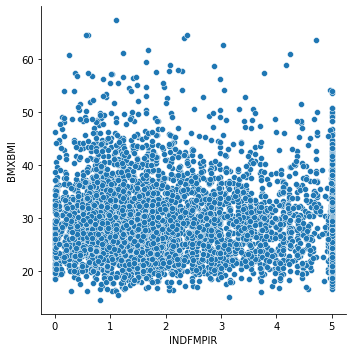

In [64]:
#Ploting scatterplots to explore relationship between income-poverty ratio and BMI 
sns.relplot(data= dfcont, x= 'INDFMPIR', y = 'BMXBMI')

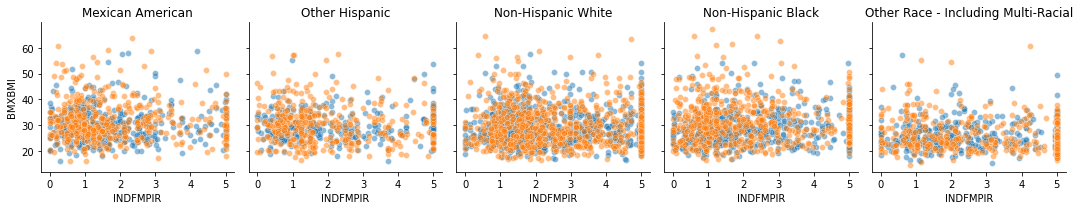

In [75]:
#Plotting facetgrid plots to explore trend of income-poverty influence on BMI in each ethnic groups
facplot = pd.concat([dfcont, dfcat.loc[:,['RIAGENDR','RIDRETH1']]], axis=1)
g = sns.FacetGrid(facplot, col='RIDRETH1', hue= 'RIAGENDR')
g.map(sns.scatterplot, 'INDFMPIR','BMXBMI', alpha = 0.5)
titles = ["Mexican American","Other Hispanic","Non-Hispanic White","Non-Hispanic Black","Other Race - Including Multi-Racial"]
axes = g.axes.flatten()
for x in range(len(titles)):
        axes[x].set_title(titles[x])

In [ ]:

# - Explore if education status affect their weight outcome
#   - Compare within sample population
#   - Compare between each Ethnic group 